### PDF Display

In [1]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

<h1><center>Robot Swarm with Single High-Level Specification</center></h1>

## Specification in Omega
Following is the result of writing the specifications using the omega toolbox.

In [2]:
from omega.games import gr1
from omega.games import enumeration as enum
from omega.symbolic import temporal as trl
from omega.games.enumeration import action_to_steps
from omega.symbolic import enumeration as sym_enum
import networkx as nx

`omega.symbolic.symbolic` failed to import `dd.cudd`.
Will use `dd.autoref`.


In [3]:
aut = trl.Automaton()
MAX_ROOMS = 2
aut.declare_variables(active=(1,MAX_ROOMS), 
                      known_room = (0, MAX_ROOMS), room = (-1, MAX_ROOMS), known = (0,1), goTo = (-1,MAX_ROOMS))
aut.varlist['env']=['active']
aut.varlist['sys']=['known_room','known','room','goTo']
aut.prime_varlists()

specs1 = open('specifications/high_level.txt','r')
specs1 = specs1.read()

aut.define(specs1)
aut.init.update(
    env='env_init',
    sys='sys_init')
aut.action.update(
    env='env_action',
    sys='sys_action')
aut.win['<>[]'] = aut.bdds_from('TRUE')
aut.win['[]<>'] = aut.bdds_from('TRUE')
aut.qinit = '\E \A'
aut.moore = True
aut.plus_one = True

z, yij, xijk = gr1.solve_streett_game(aut)
gr1.make_streett_transducer(z, yij, xijk, aut)
aut.varlist['sys'].append('_goal')
aut.prime_varlists()
# enumerate
g1 = enum.action_to_steps(aut, 'env', 'impl', qinit=aut.qinit)
h, _ = sym_enum._format_nx(g1)
pd = nx.drawing.nx_pydot.to_pydot(h)
pd.write_pdf('outputs/high_level.pdf')
PDF('outputs/high_level.pdf',size=(900,900))

In [4]:
aut = trl.Automaton()
MAX_ROOMS = 2
aut.declare_variables(active=(1,MAX_ROOMS), 
                      known_room = (0, MAX_ROOMS), room = (-1, MAX_ROOMS), known = (0,1), goTo = (-1,MAX_ROOMS))
aut.varlist['env']=['active']
aut.varlist['sys']=['known_room','known','room','goTo']
aut.prime_varlists()

specs2 = open('specifications/high_level_2.txt','r')
specs2 = specs2.read()

aut.define(specs2)
aut.init.update(
    env='env_init',
    sys='sys_init')
aut.action.update(
    env='env_action',
    sys='sys_action')
aut.win['<>[]'] = aut.bdds_from('TRUE')
aut.win['[]<>'] = aut.bdds_from('TRUE')
aut.qinit = '\E \A'
aut.moore = True
aut.plus_one = True

z, yij, xijk = gr1.solve_streett_game(aut)
gr1.make_streett_transducer(z, yij, xijk, aut)
aut.varlist['sys'].append('_goal')
aut.prime_varlists()
# enumerate
g2 = enum.action_to_steps(aut, 'env', 'impl', qinit=aut.qinit)
h, _ = sym_enum._format_nx(g2)
pd = nx.drawing.nx_pydot.to_pydot(h)
pd.write_pdf('outputs/high_level_2.pdf')
PDF('outputs/high_level_2.pdf',size=(900,900))

## Swarm-Robot Class

In [5]:
from numpy import array as array
from numpy import linalg as LA
from numpy import array_equal as equals

class Robot:
    #Edit these constants to change physical location of
    ROOMS = array([[0,0],[0,10],[15,0]])
    
    N = array([0,1])
    E = array([1,0])
    S = array([0,-1])
    W = array([-1,0])
    
    def __init__(self, strategy, node = 0):
        self.node = node
        self.strategy = strategy
        self.goTo = self.strategy._node.get(self.node)['goTo']
        self.room = self.strategy._node.get(self.node)['room']
        self.pos = self.ROOMS[0]
        self.known = self.strategy._node.get(self.node)['known']
        self.known_room = self.strategy._node.get(self.node)['known_room']
    
    def move(self,environment):
        self.propagate()
        
        cond1 = self.room == -1
        condTemp = False
        for i in range(len(self.ROOMS)):
            condTemp = condTemp or (self.pos==self.ROOMS[i]).all()
            
        cond1 = cond1 and condTemp
        
        cond2 = False
        for i in range(len(self.ROOMS)):
            cond2 = cond2 or self.room == i and not equals(self.pos,self.ROOMS[i])
        
        if cond1 or cond2:
            successors = list(self.strategy._succ[self.node].keys())
            if environment == 1:
                for suc in successors:
                    if self.strategy._node.get(suc)['active'] == 1:
                        self.node = suc
            elif environment == 2:
                for suc in successors:
                    if self.strategy._node.get(suc)['active'] == 2:
                        self.node = suc
            self.goTo = self.strategy._node.get(self.node)['goTo']
            self.room = self.strategy._node.get(self.node)['room']
            self.known = self.strategy._node.get(self.node)['known']
            self.known_room = self.strategy._node.get(self.node)['known_room'] 
            
            
    def propagate(self):
        if self.room == -1:
            if (self.ROOMS[self.goTo] - self.pos)[0] > 0:
                self.pos = self.pos + self.E
            elif (self.ROOMS[self.goTo] - self.pos)[0] < 0:
                self.pos = self.pos + self.W
            elif (self.ROOMS[self.goTo] - self.pos)[0] == 0:
                self.pos = self.pos

            if (self.ROOMS[self.goTo] - self.pos)[1] > 0:
                self.pos = self.pos + self.N
            elif (self.ROOMS[self.goTo] - self.pos)[1] < 0:
                self.pos = self.pos + self.S
            elif (self.ROOMS[self.goTo] - self.pos)[1] == 0:
                self.pos = self.pos
            
        elif self.room > -1:
            AVERAGE = 0
            for i in range(len(self.ROOMS)):
                AVERAGE = AVERAGE + self.ROOMS[i]
            AVERAGE = AVERAGE/len(self.ROOMS)
            if (AVERAGE - self.pos)[0] > 0:
                self.pos = self.pos + self.E
            elif (AVERAGE - self.pos)[0] < 0:
                self.pos = self.pos + self.W
            elif (AVERAGE - self.pos)[0] == 0:
                self.pos = self.pos

            if (AVERAGE - self.pos)[1] > 0:
                self.pos = self.pos + self.N
            elif (AVERAGE - self.pos)[1] < 0:
                self.pos = self.pos + self.S
            elif (AVERAGE - self.pos)[1] == 0:
                self.pos = self.pos

## Simulation

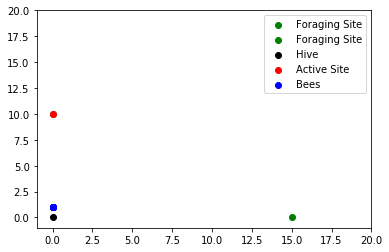

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
swarmSize = 20
population = [0]*swarmSize

for i in range(len(population)):
    if i < swarmSize/2:
        population[i] = Robot(g1)
    else:
        population[i] = Robot(g2)
        
run = True
environment = int(input('Environment is: '))
while run:
    for j in range(len(population)):
        population[j].move(environment)
        
    for i in range(1, len(population[0].ROOMS)):
        plt.scatter(population[0].ROOMS[i][0],population[0].ROOMS[i][1], c = 'green')
    plt.scatter(population[0].ROOMS[0][0],population[0].ROOMS[0][1], c = 'black')
    plt.scatter(population[0].ROOMS[environment][0],population[0].ROOMS[environment][1], c = 'red')
    for j in range(len(population)):
        plt.scatter(population[j].pos[0],population[j].pos[1], c = 'blue')
    plt.legend(['Foraging Site','Foraging Site','Hive','Active Site','Bees'])
    plt.axis([-1, 20, -1, 20])
    plt.show()
    plt.close()
    
    environment = int(input('Environment is: '))

    if environment == 0:
        run = False
    clear_output(wait=True)